<a href="https://colab.research.google.com/github/YingxiaoYan/TopSecret/blob/main/project1_runtimeR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Classification

## Part 1: Geometry of the feature space

### Question 1

What assumptions do the following methods make about the distribution of features for a certain class? What does this mean abstractly but also visually?

1.  Linear Discrimant Analysis:

-   Probability density functions are the normal distribution with mean and covariance parameters
-   The classes covariances are assumed to be identical

2.  Quadratic Discriminant Analysis:

-   Probability density functions are the normal distribution with mean and covariance parameters
-   The classes covariances are not assumed to be identical but can differ from each other

3.  kNN:

-   It assumes that similar things exist in close proximity (similar things are near to each other)
-   Appropriate scaling is necessary as the determination of the neighbors is based on distance measures
-   No assumptions regarding probability density functions or probability measures

4.  CART:

-   Assuming locally constant conditional means
-   No assumptions regarding probability density function (distribution) or variance as it is a non-statistical approach
-   Data can be partitioned into a set of rectangles with lines which are in one feature



### Question 2
(1) Data simulation

In [1]:
#rm(list = ls())
install.packages("tidyverse")
library(tidyverse)
install.packages("rpart")
library(rpart)
install.packages("mvtnorm")
library(mvtnorm)
install.packages("pracma")
library(pracma)
install.packages("MASS")
library(MASS)

##5000 data, 4000 training data, 1000 test data
n_runs = 25
rel_test <- 0.2
n_all <- 5000
n_test <- ceiling(n_all * rel_test)
n_train <- n_all - n_test

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘pracma’


The following object is masked from ‘package:purrr’:

    cross


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



#### Simulating data for QDA
The assumption is that p(x|i) for each class is normal distributed.

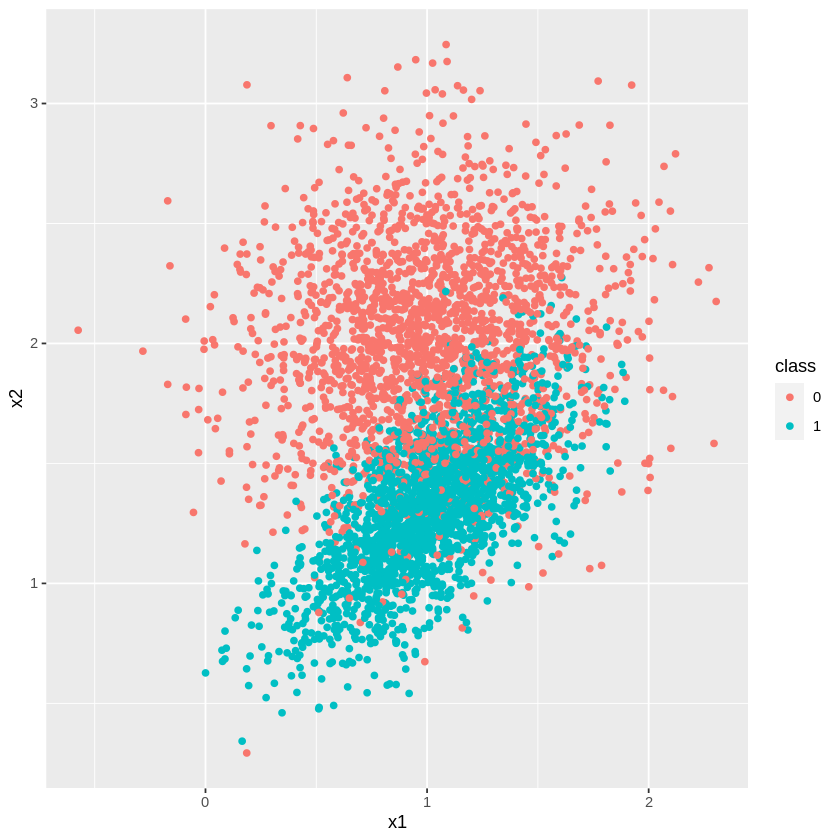

In [2]:
simulate_data_qda <- function(n_all, n_train, seed){
  set.seed(103 * seed + 1)
  n_pos <- ceiling(n_all / 2)
  mean_pos <- c(1, 1.3)
  cov_pos <- matrix(c(0.3, -0.25, -0.25, 0.3), ncol = 2)^2    # build a covarience matrix
  X_qda_pos <- rmvnorm(n_pos, mean_pos, cov_pos)   # Meet the assumption that from a normal distributrion
  Y_qda_pos <- c(rep(1, n_pos))
  
  n_neg <- n_all - n_pos
  mean_neg <- c(1, 2)
  cov_neg <- matrix(c(0.4, 0.1, 0.1, 0.4), ncol = 2)^2
  X_qda_neg <- rmvnorm(n_neg, mean_neg, cov_neg)   # sample from the distribution
  Y_qda_neg <- c(rep(0, n_neg))
  
  X_qda <- rbind(X_qda_pos, X_qda_neg)
  Y_qda <- c(Y_qda_pos, Y_qda_neg)
  ids_qda_rand <- sample(n_all)  # indices_qda_random_sampling
  X_train_qda <- X_qda[ids_qda_rand[1:n_train],]
  Y_train_qda <- Y_qda[ids_qda_rand[1:n_train]]
  X_test_qda <- X_qda[ids_qda_rand[(n_train + 1):n_all],]
  Y_test_qda <- Y_qda[ids_qda_rand[(n_train + 1):n_all]]
  
  data_train_qda <- tibble(class = as.factor(Y_train_qda),
                            x1 = X_train_qda[,1],	
                            x2 = X_train_qda[,2])
  data_test_qda <- tibble(x1 = X_test_qda[,1],	
                          x2 = X_test_qda[,2])
  data_qda <- list(X_train = X_train_qda, Y_train = Y_train_qda,
                   X_test = X_test_qda, Y_test = Y_test_qda, 
                   data_train = data_train_qda, data_test = data_test_qda)
  return(data_qda)
}

data_qda <- simulate_data_qda(n_all, n_train, 1)

ggplot(data_qda$data_train, aes(x = x1, y = x2, colour = class)) + geom_point()

#### Simulating data for CART
The assumption are locally constant conditional probabilities.

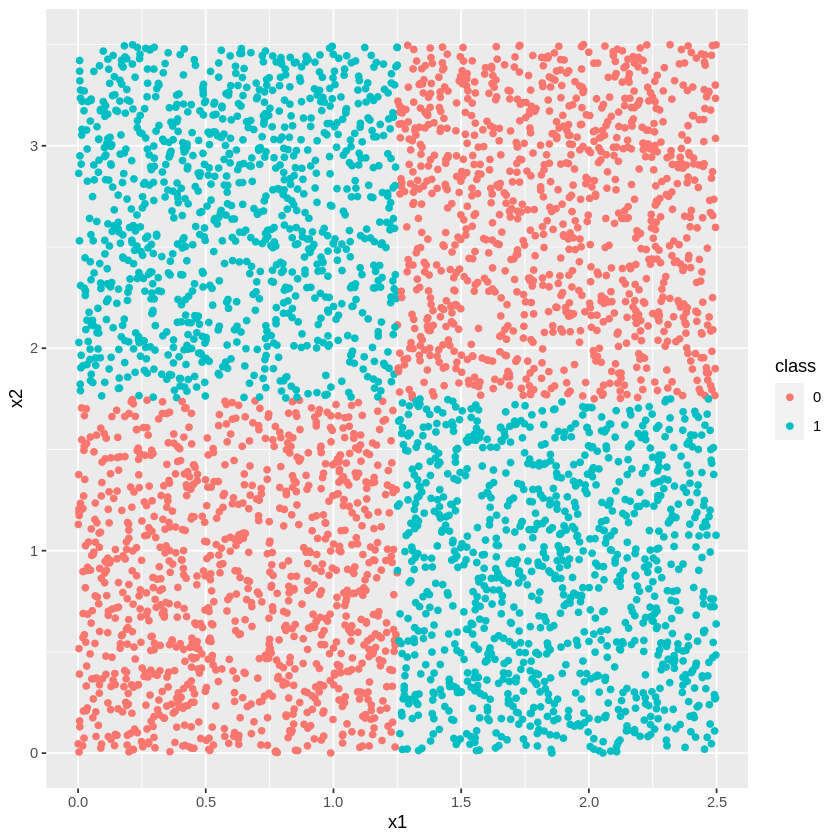

In [3]:
simulate_data_cart <- function(n_all, n_train, seed){
  set.seed(97 * seed + 9)
  e <- 0.0
  n_pos_1 <- ceiling(n_all / 4)
  n_pos_2 <- floor(n_all / 4)
  X1_cart_pos <- c(runif(n_pos_1, min = 0, max = 1.25 + e),	   # blue
                  runif(n_pos_2, min = 1.25 - e, max = 2.5))
  X2_cart_pos <- c(runif(n_pos_1, min = 1.75 - e, max = 3.5),
                  runif(n_pos_2, min = 0, max = 1.75 + e))
  X_cart_pos <- matrix(c(X1_cart_pos, X2_cart_pos), ncol = 2)
  Y_cart_pos <- c(rep(1, n_pos_1 + n_pos_2))
  
  n_neg_1 <- ceiling(n_all / 4)
  n_neg_2 <- n_all - n_pos_1 - n_pos_2 - n_neg_1
  X1_cart_neg <- c(runif(n_neg_1, min = 1.25 - e , max = 2.5),	   # red
                  runif(n_neg_2, min = 0, max = 1.25 + e))
  X2_cart_neg <- c(runif(n_neg_1, min = 1.75 - e, max = 3.5),
                  runif(n_neg_2, min = 0, max = 1.75 + e))
  X_cart_neg <- matrix(c(X1_cart_neg, X2_cart_neg), ncol = 2)
  Y_cart_neg <- c(rep(0, n_neg_1 + n_neg_2))
  X_cart <- rbind(X_cart_pos, X_cart_neg)
  Y_cart <- c(Y_cart_pos, Y_cart_neg)
  
  ids_cart_rand = sample(n_all)
  X_train_cart = X_cart[ids_cart_rand[1:n_train],]
  Y_train_cart = Y_cart[ids_cart_rand[1:n_train]]
  X_test_cart = X_cart[ids_cart_rand[(n_train + 1):n_all],]
  Y_test_cart = Y_cart[ids_cart_rand[(n_train + 1):n_all]]
  
  data_train_cart <- tibble(class = as.factor(Y_train_cart),
                            x1 = X_train_cart[,1],	x2 = X_train_cart[,2])
  data_test_cart <- tibble(x1 = X_test_cart[,1],	x2 = X_test_cart[,2])
  data_cart <- list(X_train = X_train_cart, Y_train = Y_train_cart,
                   X_test = X_test_cart, Y_test = Y_test_cart, 
                   data_train = data_train_cart, data_test = data_test_cart)
  return(data_cart)
}

data_cart <- simulate_data_cart(n_all, n_train, 1)

ggplot(data_cart$data_train, aes(x = x1, y = x2, colour = class)) + geom_point()

(2) Expectation on the test error

If QDA is applied on data simulated for CART, the test error becomes bigger comparing to applying QDA.
If CART is applied on data simulated for QDA,the test error becomes bigger comparing to applying CART.

 (3)Train and predict

In [4]:
# The first item means method that will be used to train the dataset,
# second means dataset simulated from this method
accuracy_qda_qda <- rep(0, n_runs)
accuracy_qda_cart <- rep(0, n_runs)
accuracy_cart_cart <- rep(0, n_runs)
accuracy_cart_qda <- rep(0, n_runs)

for (i_run in c(seq(1, n_runs))) {

  data_qda <- simulate_data_qda(n_all, n_train, i_run)
  data_cart <- simulate_data_cart(n_all, n_train, i_run)
  
  qda_model_qda <- qda(data_qda$X_train, grouping = data_qda$Y_train)
  Y_predict_qda_qda <- predict(qda_model_qda, data_qda$X_test)$class
  accuracy_qda_qda[i_run] <- sum(Y_predict_qda_qda == data_qda$Y_test) / n_test
  
  qda_model_cart <- qda(data_cart$X_train, grouping = data_cart$Y_train)
  Y_predict_qda_cart <- predict(qda_model_cart, data_cart$X_test)$class
  accuracy_qda_cart[i_run] <- sum(Y_predict_qda_cart == data_cart$Y_test) / n_test

  cart_model_cart <- rpart(class ~ x1 + x2, data_cart$data_train, parms = list(split = "gini"))
  Y_predict_cart_cart <- predict(cart_model_cart, newdata = data_cart$data_test, type = "class")  # classification 
  accuracy_cart_cart[i_run] <- sum(Y_predict_cart_cart == data_cart$Y_test) / n_test
  
  cart_model_qda <- rpart(class ~ x1 + x2, data_qda$data_train, parms = list(split = "gini"))
  Y_predict_cart_qda <- predict(cart_model_qda, newdata =data_qda$data_test, type = "class")
  accuracy_cart_qda[i_run] <- sum(Y_predict_cart_qda == data_qda$Y_test) / n_test
}

print(mean(accuracy_qda_qda))
print(sqrt(var(accuracy_qda_qda)))
print(mean(accuracy_cart_qda))
print(sqrt(var(accuracy_cart_qda)))
print(mean(accuracy_qda_cart))
print(sqrt(var(accuracy_qda_cart)))
print(mean(accuracy_cart_cart))
print(sqrt(var(accuracy_cart_cart)))


[1] 0.87224
[1] 0.008437417
[1] 0.85652
[1] 0.01109099
[1] 0.98852
[1] 0.004114203
[1] 0.9938
[1] 0.005469613


For dataset simulated from QDA, applying QDA on the data is more accurate for prediction than applying CART.
For dataset simulated from CART, applying CART on the data is more accurate for prediction than applying QDA.

(4) To simulate data that target method work best

To simulate data that makes target method work best is to simulate data that meet the assumptions of target method best.

For QDA, the assumption is probability density functions are the normal distribution with mean and covariance parameters

For CART, the assumption is assuming locally constant conditional means/probabilities

Takeing CART as an example and gradually adjust the data to deviate it from CART's assumption:

#### Visualization of using QDA to predict data simulated for CART

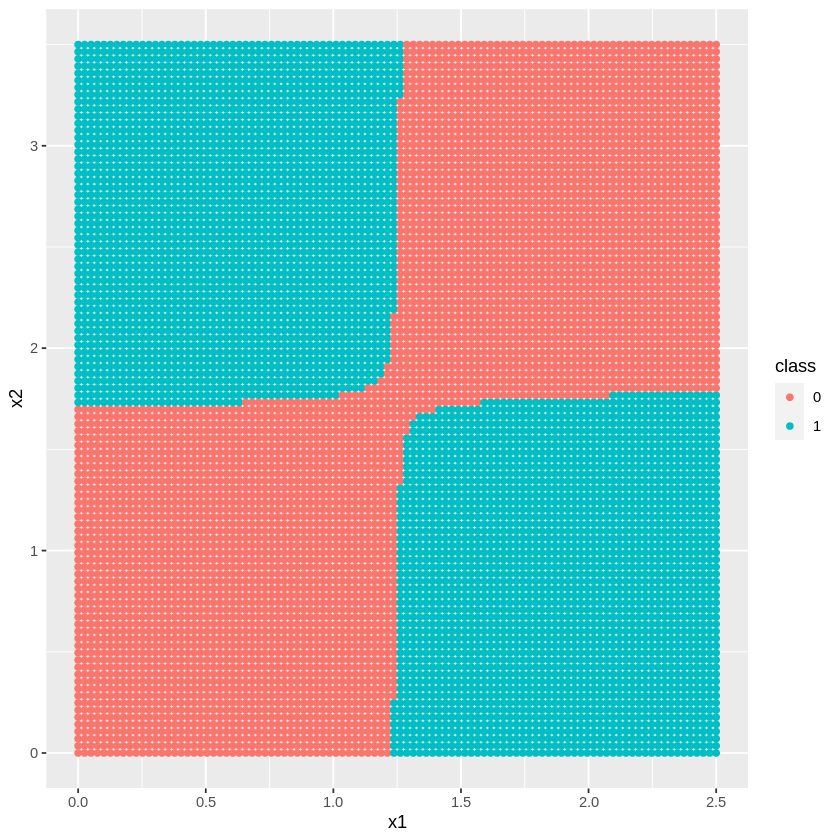

In [7]:
A <- meshgrid(seq(0, 2.5, length.out = 100), y = seq(0, 3.5, length.out = 100))
X_test_vis <- matrix(c(c(A$X), c(A$Y)), ncol = 2)
data_test_vis <- tibble(x1 = X_test_vis[,1],	x2 = X_test_vis[,2])

#Y_predict_vis <- predict(qda_model_qda, X_test_vis)$class
Y_predict_vis <- predict(qda_model_cart, X_test_vis)$class
#Y_predict_vis <- predict(cart_model_cart, newdata =data_test_vis, type = "class")
#Y_predict_vis <- predict(cart_model_qda, newdata =data_test_vis, type = "class")

data_predict_vis <- tibble(class = as.factor(Y_predict_vis),
                           x1 = data_test_vis$x1,	x2 = data_test_vis$x2)
ggplot(data_predict_vis, aes(x = x1, y = x2, colour = class)) + geom_point()

## Part 2: Actual data and classification metrics


In [1]:
install.packages("readr")
install.packages("tibble")
install.packages("dplyr")
install.packages("ipred")
library(readr)
library(tibble)
library(dplyr)
library(ipred)
install.packages("rpart")
library(rpart)
install.packages("pROC")
library(pROC)
install.packages("caret")
library(caret)
names <- c("id_number", "diagnosis", "radius_mean",
          "texture_mean", "perimeter_mean", "area_mean",
          "smoothness_mean", "compactness_mean",
          "concavity_mean","concave_points_mean",
          "symmetry_mean", "fractal_dimension_mean",
          "radius_se", "texture_se", "perimeter_se",
          "area_se", "smoothness_se", "compactness_se",
          "concavity_se", "concave_points_se",
          "symmetry_se", "fractal_dimension_se",
          "radius_worst", "texture_worst",
          "perimeter_worst", "area_worst",
          "smoothness_worst", "compactness_worst",
          "concavity_worst", "concave_points_worst",
          "symmetry_worst", "fractal_dimension_worst")

uci_bc_data <- read_delim(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",
  delim = ",",
  col_names = names,
  col_types = cols(
    .default = col_number(),
    id_number = col_integer(),
    diagnosis = col_factor()
  ))



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’, ‘progressr’, ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘p

In [2]:
Y <- uci_bc_data %>% 
  dplyr::mutate(diagnosis = as.factor(case_when(diagnosis == "B" ~ 0, diagnosis == "M" ~ 1))) %>% 
  dplyr::select(diagnosis) %>%
  as.vector() 
table(Y)  ##0 357, 1 212 
X <- uci_bc_data %>% 
  dplyr::select(-id_number, -diagnosis) %>%
  as.matrix()


Y
  0   1 
357 212 

The class labels are imbalanced. There are 357 benign and 212 maglign.

[1] "area_mean"

[1] "area_worst"

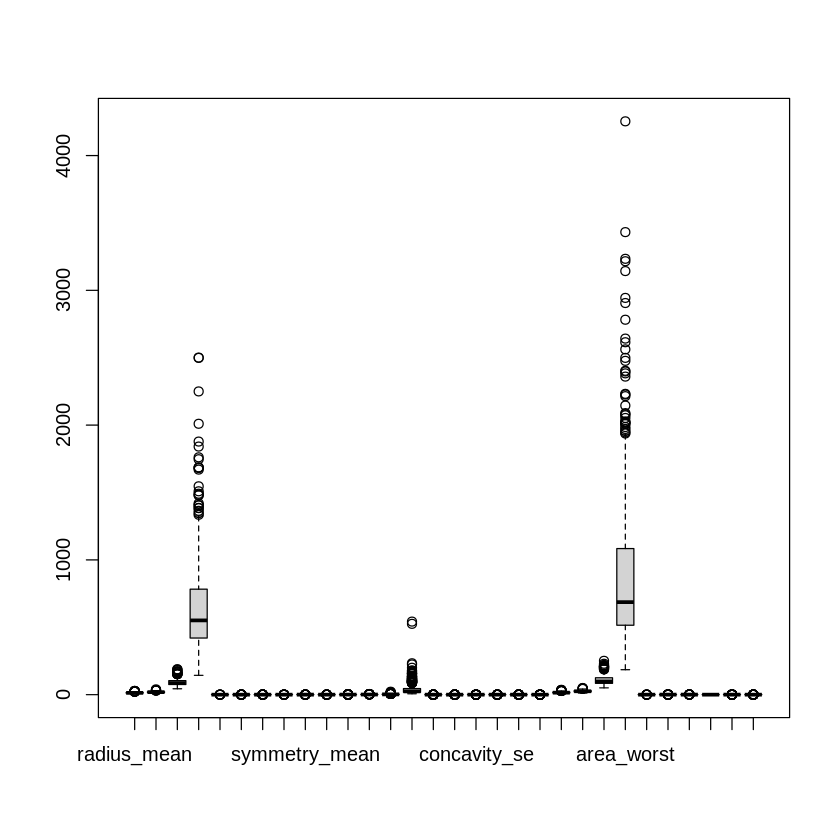

In [9]:
boxplot(X)
colnames(X)[4]
colnames(X)[24]

The features have highly varying scales. From the boxplot, we can see that "area_mean","area_worst" has larger scale than other variables

Whether the data needs to be scaled/centered/normalized depends on the classification methods chosen.

Tree based models are not distance based models and can handle varying ranges of features. Hence, Scaling is not required while modelling trees.

Algorithms like Linear Discriminant Analysis(LDA), Naive Bayes are by design equipped to handle this and gives weights to the features accordingly. Performing a features scaling in these algorithms may not have much effect.

k-nearest neighbors with an Euclidean distance measure is sensitive to magnitudes and hence should be scaled for all features to weigh in equally.

[1] 30

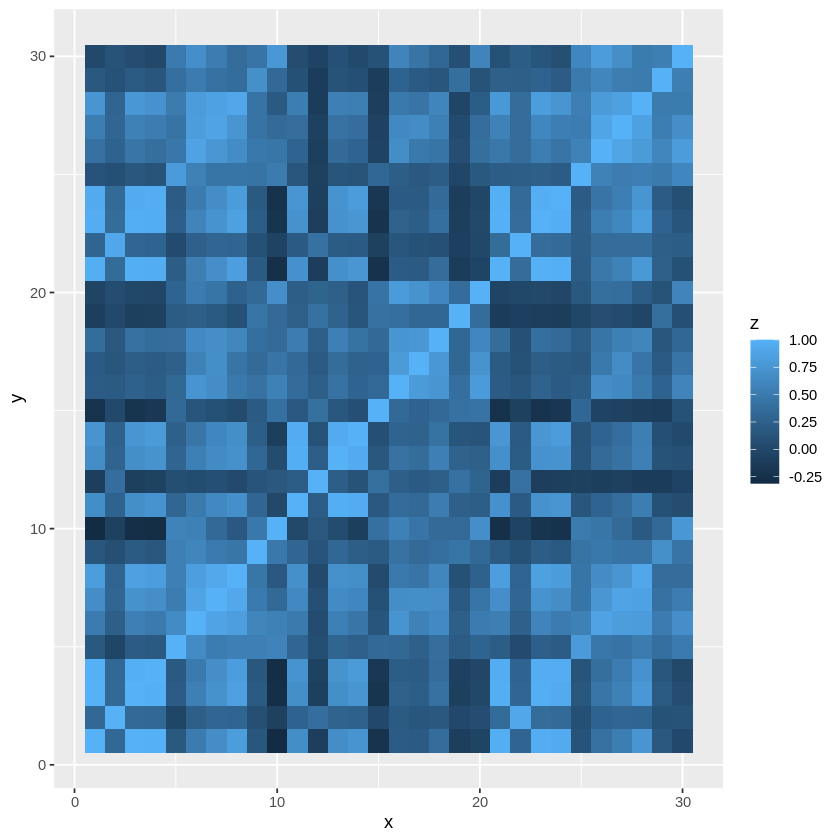

In [24]:

library(pracma)
library(tidyverse)
dim(X)[2]
cor_matrix<-cor(X)
mesh <- meshgrid(seq(1, dim(X)[2]), y = seq(1, dim(X)[2]))
data_cov <- tibble(x = c(mesh$X), y = c(mesh$Y), z = c(cor_matrix))
ggplot(data_cov, aes(x = x, y = y, fill = z)) + geom_tile()

The correlation matrix between features is shown as the heatmap above. The features with a strong correlation (>0.75|<(-0.75) are listed below.

In [29]:
cor_matrix<-round(cor(X),3)
cor_matrix_TF<-(cor_matrix>0.75|cor_matrix<(-0.75))
for (i in 1:nrow(cor_matrix)){
  for (j in 1:ncol(cor_matrix)){
    if(i!=j){
    if (cor_matrix[i,j]>0.75|cor_matrix[i,j]<(-0.75)){
      cat(rownames(cor_matrix)[i],"and",colnames(cor_matrix)[j],"correlation is",cor_matrix[i,j],'\n')
    }
    }
  }
}

radius_mean and perimeter_mean correlation is 0.998 
radius_mean and area_mean correlation is 0.987 
radius_mean and concave_points_mean correlation is 0.823 
radius_mean and radius_worst correlation is 0.97 
radius_mean and perimeter_worst correlation is 0.965 
radius_mean and area_worst correlation is 0.941 
texture_mean and texture_worst correlation is 0.912 
perimeter_mean and radius_mean correlation is 0.998 
perimeter_mean and area_mean correlation is 0.987 
perimeter_mean and concave_points_mean correlation is 0.851 
perimeter_mean and radius_worst correlation is 0.969 
perimeter_mean and perimeter_worst correlation is 0.97 
perimeter_mean and area_worst correlation is 0.942 
perimeter_mean and concave_points_worst correlation is 0.771 
area_mean and radius_mean correlation is 0.987 
area_mean and perimeter_mean correlation is 0.987 
area_mean and concave_points_mean correlation is 0.823 
area_mean and area_se correlation is 0.8 
area_mean and radius_worst correlation is 0.963 


Some of the correlations exist because one variable is calculated from the other variable. For example, perimeter radius is directly calculated from radius. There is high correlation (0.998) between radius mean and perimeter mean.

Question 3: Comparing classfication metrics

 (1) Choose CART to test the effect of different classification matrix (accuracy, sensitivity, specificity, precision, F1_score, MCC, AUC)

Split the data

In [ ]:
###This is to build a function of randomly spliting 
split_randomly<-function(data,k){
  n=nrow(data)
  remains=n%%k
  split_plus1<-split(data, sample(rep(1:(k+1),times=c(rep(n%/%k,k),remains))))
  for(i in 1:remains)
  {split_plus1[[i]]<-rbind(split_plus1[[i]],split_plus1[[k+1]][i,])}
  split_samples<-list()
  for (j in 1:k){
    split_samples[[j]]<-split_plus1[[j]]
  }
  return(split_samples)
}
data<-cbind(X,Y)
colnames(data)
k<-10
data_folds<-split_randomly(data,k)

[1] "radius_mean"             "texture_mean"           
 [3] "perimeter_mean"          "area_mean"              
 [5] "smoothness_mean"         "compactness_mean"       
 [7] "concavity_mean"          "concave_points_mean"    
 [9] "symmetry_mean"           "fractal_dimension_mean" 
[11] "radius_se"               "texture_se"             
[13] "perimeter_se"            "area_se"                
[15] "smoothness_se"           "compactness_se"         
[17] "concavity_se"            "concave_points_se"      
[19] "symmetry_se"             "fractal_dimension_se"   
[21] "radius_worst"            "texture_worst"          
[23] "perimeter_worst"         "area_worst"             
[25] "smoothness_worst"        "compactness_worst"      
[27] "concavity_worst"         "concave_points_worst"   
[29] "symmetry_worst"          "fractal_dimension_worst"
[31] "diagnosis"

For each fold F, train a model

In [ ]:
test_set<-list()
test_set_X<-list()
test_set_Y<-list()
training_set<-list()
training_set_X<-list()
training_set_Y<-list()
cart_model<-list()
Y_predict_cart<-list()
for(i in 1:k){
training_set[[i]]<-data[-as.numeric(rownames(data_folds[[i]])),]
test_set[[i]]<-data[as.numeric(rownames(data_folds[[i]])),]
training_set_X[[i]]<-training_set[[i]][,1:(ncol(training_set[[i]])-1)]
training_set_Y[[i]]<-training_set[[i]][,ncol(training_set[[i]])]
test_set_X[[i]]<-test_set[[i]][,1:(ncol(test_set[[i]])-1)]
test_set_Y[[i]]<-test_set[[i]][,ncol(test_set[[i]])]
cat(i,"round")
  cart_model[[i]] <- rpart(
  formula=as.formula(paste(colnames(training_set[[i]])[ncol(training_set[[i]])],'~', paste(colnames(training_set_X[[i]]),collapse="+"))),
  training_set[[i]], 
  parms = list(split = "gini")
  )
  Y_predict_cart[[i]] <- predict(cart_model[[i]], newdata = test_set_X[[i]], type = "class")  ##classification 
}


1 round2 round3 round4 round5 round6 round7 round8 round9 round10 round

Compute classfication matrix on the test fold

In [ ]:
Performance<-function(predict,actual){
  result<-list()
  confusion<-confusionMatrix(reference=actual,data=predict)
###Here true positive is defined as the patients with malignant tumor are dignosed with malignant tumor 
##Note that the sensitivity is different as caculated using confusionMatrix function since the dinifition of true positive is different
  TP<-confusion$table[2,2]
  TN<-confusion$table[1,1]
  FP<-confusion$table[2,1]
  FN<-confusion$table[1,2]
  result$accuracy<-(TP+TN)/(TP+TN+FP+FN)
  result$sensitivity<- TP/(TP+FN)
  result$specificity<-TN/(TN+FP) 
  result$precision<- TP/(TP+FP)
  result$F1_score<-2*(result$precision*result$sensitivity)/(result$precision+result$sensitivity)
  result$MCC<- (TP*TN-FP*FN)/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  result$AUC<-auc(as.numeric(as.vector(actual)),as.numeric(predict))
  return(result)
}

In [ ]:
performance_list<-list()
accuracy<-vector()
sensitivity<-vector()
specificity<-vector()
precision<-vector()
F1_score<-vector()
MCC<-vector()
AUC<-vector()
for (i in 1:k){
performance_list[[i]]<-Performance(Y_predict_cart[[i]],test_set_Y[[i]])
accuracy<-c(accuracy,performance_list[[i]]$accuracy)
sensitivity<-c(sensitivity,performance_list[[i]]$sensitivity)
specificity<-c(specificity,performance_list[[i]]$specificity)
precision<-c(precision,performance_list[[i]]$precision)
F1_score<-c(F1_score,performance_list[[i]]$F1_score)
MCC<-c(MCC,performance_list[[i]]$MCC)
AUC<-c(AUC,performance_list[[i]]$AUC)
}


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Report the average performance across folds

In [ ]:
accuracy_mean_CART<-mean(accuracy)
sensitivity_mean_CART<-mean(sensitivity)
specificity_mean_CART<-mean(specificity)
precision_mean_CART<-mean(precision)
F1_score_mean_CART<-mean(F1_score)
MCC_mean_CART<-mean(MCC)
AUC_mean_CART<-mean(AUC)
cat(accuracy_mean_CART,"accuracy_mean",'\n')
cat(sensitivity_mean_CART,"sensitivity_mean",'\n')
cat(specificity_mean_CART,"specificity_mean",'\n')
cat(precision_mean_CART,"precision_mean",'\n')
cat(F1_score_mean_CART,"F1_score_mean",'\n')
cat(MCC_mean_CART,"MCC_mean",'\n')
cat(AUC_mean_CART,"AUC_mean",'\n')

0.9068609 accuracy_mean 
0.8810603 sensitivity_mean 
0.9173305 specificity_mean 
0.8772038 precision_mean 
0.8731425 F1_score_mean 
0.8043338 MCC_mean 
0.8991954 AUC_mean 


(2) Sensitivity is most suitable for my goal. Since the goal is to discover most patients with malignment tumors (positive) and give them treatment on time, we want to dectect as much false negative as possible (the costs of false negatives are high.).

(3) Choose LDA for additional classification 
Comparing 2 methods using the best classification matrix

In [ ]:
library(ipred)
unloadNamespace("caret")
unloadNamespace("recipes")
unloadNamespace("ipred")
library(MASS)

In [ ]:
test_set<-list()
test_set_X<-list()
test_set_Y<-list()
training_set<-list()
training_set_X<-list()
training_set_Y<-list()
lda_model<-list()
Y_predict_lda<-list()
for(i in 1:k){
training_set[[i]]<-data[-as.numeric(rownames(data_folds[[i]])),]
test_set[[i]]<-data[as.numeric(rownames(data_folds[[i]])),]
training_set_X[[i]]<-training_set[[i]][,1:(ncol(training_set[[i]])-1)]
training_set_Y[[i]]<-training_set[[i]][,ncol(training_set[[i]])]
test_set_X[[i]]<-test_set[[i]][,1:(ncol(test_set[[i]])-1)]
test_set_Y[[i]]<-test_set[[i]][,ncol(test_set[[i]])]
cat(i,"round")
  lda_model[[i]] <- lda(training_set[[i]][,1:(ncol(test_set[[i]])-1)],training_set[[i]][,"diagnosis"],
  )
  Y_predict_lda[[i]] <- predict(lda_model[[i]], newdata = test_set_X[[i]], type = "class")  ##classification 
}


1 round2 round3 round4 round5 round6 round7 round8 round9 round10 round

In [ ]:

library(caret)
performance_list<-list()
accuracy<-vector()
sensitivity<-vector()
specificity<-vector()
precision<-vector()
F1_score<-vector()
MCC<-vector()
AUC<-vector()
for (i in 1:k){
performance_list[[i]]<-Performance(Y_predict_lda[[i]]$class,test_set_Y[[i]])
accuracy<-c(accuracy,performance_list[[i]]$accuracy)
sensitivity<-c(sensitivity,performance_list[[i]]$sensitivity)
specificity<-c(specificity,performance_list[[i]]$specificity)
precision<-c(precision,performance_list[[i]]$precision)
F1_score<-c(F1_score,performance_list[[i]]$F1_score)
MCC<-c(MCC,performance_list[[i]]$MCC)
AUC<-c(AUC,performance_list[[i]]$AUC)
}


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [ ]:
accuracy_mean_lda<-mean(accuracy)
sensitivity_mean_lda<-mean(sensitivity)
specificity_mean_lda<-mean(specificity)
precision_mean_lda<-mean(precision)
F1_score_mean_lda<-mean(F1_score)
MCC_mean_lda<-mean(MCC)
AUC_mean_lda<-mean(AUC)
cat(accuracy_mean_lda,accuracy_mean_CART,"accuracy_mean",'\n')
cat(sensitivity_mean_lda,sensitivity_mean_CART,"sensitivity_mean",'\n')
cat(specificity_mean_lda,specificity_mean_CART,"specificity_mean",'\n')
cat(precision_mean_lda,precision_mean_CART,"precision_mean",'\n')
cat(F1_score_mean_lda,F1_score_mean_CART,"F1_score_mean",'\n')
cat(MCC_mean_lda,MCC_mean_CART,"MCC_mean",'\n')
cat(AUC_mean_lda,AUC_mean_CART,"AUC_mean",'\n')

0.9560464 0.9068609 accuracy_mean 
0.8930789 0.8810603 sensitivity_mean 
0.994267 0.9173305 specificity_mean 
0.990389 0.8772038 precision_mean 
0.9384281 0.8731425 F1_score_mean 
0.9076502 0.8043338 MCC_mean 
0.943673 0.8991954 AUC_mean 


LDA has higher sensitvity than CART 

(4) Using stratified cross-validation

In [ ]:
fold<-createFolds(data$diagnosis, k = 10)  ###stratified spliting
data_folds<-list()
for(i in 1:k){
data_folds[[i]]<-data[fold[[i]],]
}


In [ ]:
library(ipred)
unloadNamespace("caret")
unloadNamespace("recipes")
unloadNamespace("ipred")
library(MASS)

In [ ]:
test_set<-list()
test_set_X<-list()
test_set_Y<-list()
training_set<-list()
training_set_X<-list()
training_set_Y<-list()
cart_model<-list()
Y_predict_cart<-list()
for(i in 1:k){
training_set[[i]]<-data[-as.numeric(rownames(data_folds[[i]])),]
test_set[[i]]<-data[as.numeric(rownames(data_folds[[i]])),]
training_set_X[[i]]<-training_set[[i]][,1:(ncol(training_set[[i]])-1)]
training_set_Y[[i]]<-training_set[[i]][,ncol(training_set[[i]])]
test_set_X[[i]]<-test_set[[i]][,1:(ncol(test_set[[i]])-1)]
test_set_Y[[i]]<-test_set[[i]][,ncol(test_set[[i]])]
cat(i,"round")
  cart_model[[i]] <- rpart(
  formula=as.formula(paste(colnames(training_set[[i]])[ncol(training_set[[i]])],'~', paste(colnames(training_set_X[[i]]),collapse="+"))),
  training_set[[i]], 
  parms = list(split = "gini")
  )
  Y_predict_cart[[i]] <- predict(cart_model[[i]], newdata = test_set_X[[i]], type = "class")  ##classification 
}

1 round2 round3 round4 round5 round6 round7 round8 round9 round10 round

In [ ]:
library(caret)
performance_list<-list()
accuracy<-vector()
sensitivity<-vector()
specificity<-vector()
precision<-vector()
F1_score<-vector()
MCC<-vector()
AUC<-vector()
for (i in 1:k){
performance_list[[i]]<-Performance(Y_predict_cart[[i]],test_set_Y[[i]])
accuracy<-c(accuracy,performance_list[[i]]$accuracy)
sensitivity<-c(sensitivity,performance_list[[i]]$sensitivity)
specificity<-c(specificity,performance_list[[i]]$specificity)
precision<-c(precision,performance_list[[i]]$precision)
F1_score<-c(F1_score,performance_list[[i]]$F1_score)
MCC<-c(MCC,performance_list[[i]]$MCC)
AUC<-c(AUC,performance_list[[i]]$AUC)
}


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [ ]:
accuracy_mean_CART<-mean(accuracy)
sensitivity_mean_CART<-mean(sensitivity)
specificity_mean_CART<-mean(specificity)
precision_mean_CART<-mean(precision)
F1_score_mean_CART<-mean(F1_score)
MCC_mean_CART<-mean(MCC)
AUC_mean_CART<-mean(AUC)
cat(accuracy_mean_CART,"accuracy_mean",'\n')
cat(sensitivity_mean_CART,"sensitivity_mean",'\n')
cat(specificity_mean_CART,"specificity_mean",'\n')
cat(precision_mean_CART,"precision_mean",'\n')
cat(F1_score_mean_CART,"F1_score_mean",'\n')
cat(MCC_mean_CART,"MCC_mean",'\n')
cat(AUC_mean_CART,"AUC_mean",'\n')

0.9313791 accuracy_mean 
0.9246753 sensitivity_mean 
0.9353175 specificity_mean 
0.8986413 precision_mean 
0.910258 F1_score_mean 
0.8566176 MCC_mean 
0.9299964 AUC_mean 


In [ ]:
test_set<-list()
test_set_X<-list()
test_set_Y<-list()
training_set<-list()
training_set_X<-list()
training_set_Y<-list()
lda_model<-list()
Y_predict_lda<-list()
for(i in 1:k){
training_set[[i]]<-data[-as.numeric(rownames(data_folds[[i]])),]
test_set[[i]]<-data[as.numeric(rownames(data_folds[[i]])),]
training_set_X[[i]]<-training_set[[i]][,1:(ncol(training_set[[i]])-1)]
training_set_Y[[i]]<-training_set[[i]][,ncol(training_set[[i]])]
test_set_X[[i]]<-test_set[[i]][,1:(ncol(test_set[[i]])-1)]
test_set_Y[[i]]<-test_set[[i]][,ncol(test_set[[i]])]
cat(i,"round")
  lda_model[[i]] <- lda(training_set[[i]][,1:(ncol(test_set[[i]])-1)],training_set[[i]][,"diagnosis"],
  )
  Y_predict_lda[[i]] <- predict(lda_model[[i]], newdata = test_set_X[[i]], type = "class")  ##classification 
}

1 round2 round3 round4 round5 round6 round7 round8 round9 round10 round

In [ ]:
performance_list<-list()
accuracy<-vector()
sensitivity<-vector()
specificity<-vector()
precision<-vector()
F1_score<-vector()
MCC<-vector()
AUC<-vector()
for (i in 1:k){
performance_list[[i]]<-Performance(Y_predict_lda[[i]]$class,test_set_Y[[i]])
accuracy<-c(accuracy,performance_list[[i]]$accuracy)
sensitivity<-c(sensitivity,performance_list[[i]]$sensitivity)
specificity<-c(specificity,performance_list[[i]]$specificity)
precision<-c(precision,performance_list[[i]]$precision)
F1_score<-c(F1_score,performance_list[[i]]$F1_score)
MCC<-c(MCC,performance_list[[i]]$MCC)
AUC<-c(AUC,performance_list[[i]]$AUC)
}

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [ ]:
accuracy_mean_lda<-mean(accuracy)
sensitivity_mean_lda<-mean(sensitivity)
specificity_mean_lda<-mean(specificity)
precision_mean_lda<-mean(precision)
F1_score_mean_lda<-mean(F1_score)
MCC_mean_lda<-mean(MCC)
AUC_mean_lda<-mean(AUC)
cat(accuracy_mean_lda,accuracy_mean_CART,"accuracy_mean",'\n')
cat(sensitivity_mean_lda,sensitivity_mean_CART,"sensitivity_mean",'\n')
cat(specificity_mean_lda,specificity_mean_CART,"specificity_mean",'\n')
cat(precision_mean_lda,precision_mean_CART,"precision_mean",'\n')
cat(F1_score_mean_lda,F1_score_mean_CART,"F1_score_mean",'\n')
cat(MCC_mean_lda,MCC_mean_CART,"MCC_mean",'\n')
cat(AUC_mean_lda,AUC_mean_CART,"AUC_mean",'\n')

0.9578872 0.9313791 accuracy_mean 
0.8965368 0.9246753 sensitivity_mean 
0.9943651 0.9353175 specificity_mean 
0.9904545 0.8986413 precision_mean 
0.9397813 0.910258 F1_score_mean 
0.9116966 0.8566176 MCC_mean 
0.9454509 0.9299964 AUC_mean 


With stratified cross validation, the sensitivity of CART imporves and the sensitivity of lda slightly decreases comparing without using stratified cross validation.

### Question 4:  Dealing with imblanced data

In [ ]:
library(readr)
library(tibble)
library(dplyr)
library(purrr)
library(MASS)
librar
names <- c("id_number", "diagnosis", "radius_mean",
          "texture_mean", "perimeter_mean", "area_mean",
          "smoothness_mean", "compactness_mean",
          "concavity_mean","concave_points_mean",
          "symmetry_mean", "fractal_dimension_mean",
          "radius_se", "texture_se", "perimeter_se",
          "area_se", "smoothness_se", "compactness_se",
          "concavity_se", "concave_points_se",
          "symmetry_se", "fractal_dimension_se",
          "radius_worst", "texture_worst",
          "perimeter_worst", "area_worst",
          "smoothness_worst", "compactness_worst",
          "concavity_worst", "concave_points_worst",
          "symmetry_worst", "fractal_dimension_worst")

uci_bc_data <- read_delim(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",
  delim = ",",
  col_names = names,
  col_types = cols(
    .default = col_number(),
    id_number = col_integer(),
    diagnosis = col_factor()
  ))

y <- uci_bc_data %>% 
  dplyr::mutate(diagnosis = as.factor(case_when(diagnosis == "B" ~ 0, diagnosis == "M" ~ 1))) %>%
  dplyr::select(diagnosis) %>%
  as_vector() %>%
  unname()
X <- uci_bc_data %>% 
  dplyr::select(-id_number, -diagnosis) %>%
  as.matrix()
install.packages("pracma")
library(pracma)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




In [ ]:

correlation <- cor(X, y=X, use="all.obs")
n_features <- dim(correlation)[1]
mesh <- meshgrid(seq(1, n_features), y = seq(1, n_features))
data_cov <- tibble(x = c(mesh$X), y = c(mesh$Y), z = c(correlation))
ggplot(data_cov, aes(x = x, y = y, fill = z)) + geom_tile()

ERROR: ignored

In [ ]:
n_features

In [ ]:
create_inbalanced_data <- function(X, y, ratio) {
  ##y is factor
  lvls <- levels(y)
  y <- as.numeric(as.character(y))
  
  n_features = dim(X)[2]
  ids_major <- which(y == 0) # majority class in y is 0
  ids_minor <- which(y == 1)
  n_major <- length(ids_major)
  n_minor <- length(ids_minor)
  n_major_targ <- ceil(ratio / ( 1 - ratio) * n_minor)
  n_aug <- n_major_targ - n_major
  X_minor <- X[ids_minor,]
  y_minor <- y[ids_minor]
  X_major <- X[ids_major,]
  y_major <- y[ids_major]

  if (n_aug < 0) {
    ids_keep <- sample(seq(1, n_major), n_major_targ)
    X_major <- X_major[ids_keep,]
    y_major <- y_major[ids_keep]
  }
  else if (n_aug > 0){
    X_aug <- matrix(0, n_aug, n_features)
    y_aug <- rep(0, n_aug) ###add it to 0 class
    
    
    for (i in c(seq(1, n_aug))) {
      samples <- sample(seq(1, n_major), 2) ###without replacement
      X_aug[i,] <- 0.95 * X_major[samples[1],] + 0.05 * X_major[samples[2],]
    }
    
    X_major <- rbind(X_major, X_aug)
    y_major <- c(y_major, y_aug)
  }
  X <- rbind(X_minor, X_major)
  y <- c(y_minor, y_major)
  ids_rand <- sample(seq(1, n_minor + n_major_targ))
  #ids_rand <- sample((n_minor + n_major_targ))
  X <- X[ids_rand,]
  y <- factor(y[ids_rand], levels = lvls)
  
  return(list(X = X, y = y))
}

In [ ]:
stratified_train_test_split <- function(X, y, test_ratio) {
  ids_neg <- which(y == 0)
  ids_pos <- which(y == 1)
  n_neg <- length(ids_neg)
  n_pos <- length(ids_pos)
  n_test_neg <- round(n_neg * test_ratio)
  n_test_pos <- round(n_pos * test_ratio)
  n_train_neg <- n_neg - n_test_neg
  n_train_pos <- n_pos - n_test_pos
  
  ##random sampling
  ids_neg_rand <- sample(ids_neg)
  ids_pos_rand <- sample(ids_pos)
  
  X_test_pos <- X[ids_pos_rand[1:n_test_pos],]
  X_test_neg <- X[ids_neg_rand[1:n_test_neg],]
  X_train_pos <- X[ids_pos_rand[(n_test_pos + 1):n_pos],]
  X_train_neg <- X[ids_neg_rand[(n_test_neg + 1):n_neg],]
  
  y_test_pos <- y[ids_pos_rand[1:n_test_pos]]
  y_test_neg <- y[ids_neg_rand[1:n_test_neg]]
  y_train_neg <- y[ids_neg_rand[(n_test_neg + 1):n_neg]]
  y_train_pos <- y[ids_pos_rand[(n_test_pos + 1):n_pos]]
  
  X_test <- rbind(X_test_neg, X_test_pos)
  y_test <- c(y_test_neg, y_test_pos)
  X_train <- rbind(X_train_neg, X_train_pos)
  y_train <- c(y_train_neg, y_train_pos)
  ##random sampling (in case of nerual network)
  ids_test_rand <- sample(length(y_test))
  ids_train_rand <- sample(length(y_train))
  
  X_test <- X_test[ids_test_rand,]
  y_test <- y_test[ids_test_rand]
  X_train <- X_train[ids_train_rand,]
  y_train <- y_train[ids_train_rand]
  
  return(list(X_test = X_test, y_test = y_test,
              X_train = X_train, y_train = y_train))
}

In [ ]:
n_runs <- 25
ratios <- c(0.5, 0.65, 0.75, 0.85, 0.95)
for (i_ratio in seq(1, length(ratios))) {
  precision <- rep(0, n_runs)
  recall <- rep(0, n_runs)
  for (i_run in c(seq(1, n_runs))) {
    data_imbal <- create_inbalanced_data(X, y, ratios[i_ratio])
    data <- stratified_train_test_split(data_imbal$X, data_imbal$y, 0.25)
    qda_model <- qda(data$X_train, grouping = data$y_train)
    y_predict <- predict(qda_model, data$X_test)$class
    tp <- sum((y_predict == 1) & (data$y_test == 1))
    fp <- sum((y_predict == 1) & (data$y_test == 0))
    fn <- sum((y_predict == 0) & (data$y_test == 1))
    precision[i_run] <- tp / (tp + fp)
    recall[i_run] <- tp / (tp + fn)
  }
  f_score <- 2 * precision * recall / (precision + recall)
  cat("ratio =", ratios[i_ratio], "\n")
  cat("Precision: mean =", mean(precision), "  standard deviation =", sqrt(var(precision)), "\n")
  cat("Recall: mean =", mean(recall), "  standard deviation =", sqrt(var(recall)), "\n")
  cat("f-Score: mean =", mean(f_score), "  standard deviation =", sqrt(var(f_score)), "\n")
  cat("\n")
}